# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка библиотек

In [108]:
import numpy as np 
import pandas as pd  
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 

!pip install fast_ml
from fast_ml.model_development import train_valid_test_split
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
import lightgbm as lgb 
import catboost as cb

from sklearn.metrics import make_scorer, mean_squared_error 

import time

RND = 12345

### Загрузка и обработка данных

In [2]:
data = pd.read_csv('autos.csv')

In [3]:
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# пропуски
display(pd.DataFrame(data.isna().sum().sort_values(ascending=False)/len(data)*100))

,0
Repaired,20.079070
VehicleType,10.579368
FuelType,9.282697
Gearbox,5.596709
Model,5.560588
DateCrawled,0.000000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000


In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17


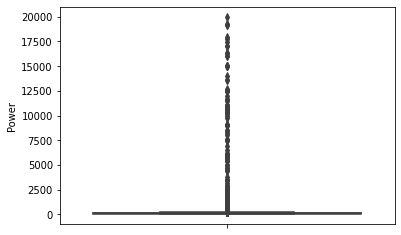

In [7]:
# мощность 
sns.boxplot(y = 'Power', data=data)
data.query("Power < 4000").head(4)

<AxesSubplot:ylabel='RegistrationYear'>

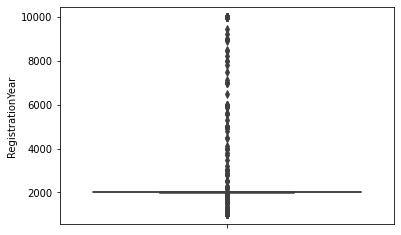

In [8]:
# Цена
sns.boxplot(y = 'RegistrationYear', data=data)

In [9]:
data.query("Price < 2")

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


 - Repaired - нет отметок, видимо эти ТС никогда не ремонтировали, заменим на "no".
 - VehicleType заменим на "other".
 - FuelType, Gearbox, Model - меньше 10%, удалим пропуски.
 - Power - явная проблема с единицами измерения, автомобили с огромными лошадиными силами в датафрейме не являются коммерческим(грузовым)транспортом, автомобили категории 'B' не имеют такую форсировку двигателя, дефорсируем их.
 - RegistrationYear нереальные года регистрации автомобилей
 - Price - объявления с подозрительно низкой ценой

In [10]:
# Заменим на "no"
data['Repaired'] = data['Repaired'].fillna('no')

In [11]:
# VehicleType заменим на "other"
data['VehicleType'] = data['VehicleType'].fillna('other')

In [12]:
# FuelType, Gearbox, Model - меньше 10%, удалим пропуски
data.dropna(axis = 0, how='any', subset =['FuelType', 'Gearbox', 'Model'], inplace=True)

In [13]:
### дефорсируем л.с.
def Balance_Power(value):
    if  1000 <= value <= 9999:
        return value/10
    elif value >10000:
        return value/100
    else:
        return value

In [14]:
data["Power"] = data["Power"].apply(Balance_Power)

count    299228.000000
mean        113.101413
std          60.692735
min           0.000000
25%          75.000000
50%         108.000000
75%         144.000000
max         999.000000
Name: Power, dtype: float64

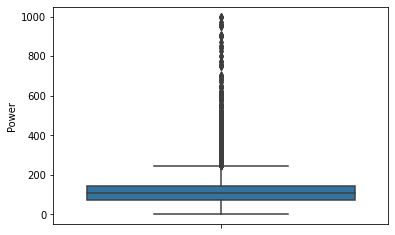

In [15]:
sns.boxplot(y = 'Power', data=data)
data['Power'].describe()

In [16]:
# вернем дату регистрации в пределах 1950/2023 г.
def Registration_Year(value):
    if value <= 1950:
        return 1950
    elif value > 2023:
        return 2023
    else:
        return value

In [17]:
data["RegistrationYear"] = data["RegistrationYear"].apply(Registration_Year)

count    299228.000000
mean       2003.090854
std           6.695766
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2023.000000
Name: RegistrationYear, dtype: float64

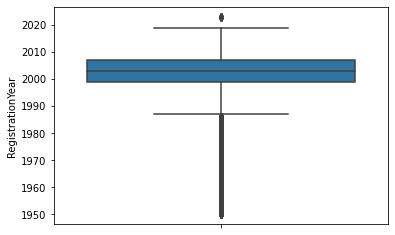

In [18]:
sns.boxplot(y = 'RegistrationYear', data=data)
data['RegistrationYear'].describe()

In [19]:
# Удаление объявлений с подозрительно низкой ценой 
data = data[(data['Price'] > 2)]

In [20]:
# Сброс индексов после обработки 
data.reset_index(drop=True, inplace= True)

- Пропуски удалены\обработаны
- Выбросы параметров мощности и года регистрации устранены 
- Данные с подозрительно низкой ценой удалены

## Обучение моделей

### Удаление данных не участвующих в обучении 

In [21]:
data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns', inplace=True)

### Разделение на выборки  

In [22]:
# Разделение на признаки и целевой признак 
features = data.drop('Price', axis=1)
target = data['Price']

In [23]:
#Делим на выборки
features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_split(data, target = 'Price', train_size=0.6, valid_size=0.2, test_size=0.2)

In [24]:
features_train.reset_index(drop= True , inplace= True )
target_train.reset_index(drop= True , inplace= True )
features_valid.reset_index(drop= True , inplace= True )
target_valid.reset_index(drop= True , inplace= True )
features_test.reset_index(drop= True , inplace= True )
target_test.reset_index(drop= True , inplace= True )

In [25]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(175624, 10)
(175624,)
(58542, 10)
(58542,)
(58542, 10)
(58542,)


### Кодирование категориальных признаков

#### Get_Dummies

In [26]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True).reset_index(drop= True , inplace= True )
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True).reset_index(drop= True , inplace= True )
features_test_ohe = pd.get_dummies(features_test, drop_first=True).reset_index(drop= True , inplace= True )

In [27]:
features_train_ohe
features_train_ohe

OrdinalEncoder

In [29]:
encoder = OrdinalEncoder(handle_unknown='ignore')
cat_cols=['VehicleType','Gearbox', 'Model','FuelType','Brand','Repaired']

In [30]:
encoder.fit(features_train[cat_cols])

OrdinalEncoder(handle_unknown='ignore')

In [31]:
features_train_oe = features_train.join(pd.DataFrame(encoder.transform(features_train[cat_cols])))
features_train_oe.drop(columns=cat_cols, axis = 1, inplace=True)

features_valid_oe = features_valid.join(pd.DataFrame(encoder.transform(features_valid[cat_cols])))
features_valid_oe.drop(columns=cat_cols, axis = 1, inplace=True)

features_test_oe = features_test.join(pd.DataFrame(encoder.transform(features_test[cat_cols])))
features_test_oe.drop(columns=cat_cols, axis = 1, inplace=True)

### Функция для метрики RMSE.

In [32]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### Константная модель

In [33]:
%%time

const_model = pd.Series(target_train.median(), index=target_train.index)

const_RMSE = round(RMSE(target_train, const_model), 3)
print('RMSE для константной модели', const_RMSE)

RMSE для константной модели 4885.518
CPU times: user 5.61 ms, sys: 284 µs, total: 5.89 ms
Wall time: 5.55 ms


### Линейная регрессия

In [34]:
%%time

regression = LinearRegression()

regression.fit(features_train_oe, target_train)

regression_cv_score = pd.Series(cross_val_score(regression,features_train_oe,target_train,scoring=RMSE_score,cv=3)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 3040.5387944791532
CPU times: user 387 ms, sys: 368 ms, total: 755 ms
Wall time: 743 ms


### Случайный лес

In [35]:
%%time

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5, 15, 5),
                     'max_depth': range(1, 6, 2),
                     'min_samples_leaf': range(1,4),
                     'min_samples_split': range(2,6,2) }


forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=3)
forest_grid.fit(features_train_oe, target_train)

CPU times: user 49.8 s, sys: 165 ms, total: 50 s
Wall time: 50.2 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 6, 2),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(5, 15, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [47]:
%%time

forest_params = forest_grid.best_params_
forest_score_train = forest_grid.score(features_train_oe, target_train) * (-1)

print(forest_params)
print(forest_score_train)

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
2361.177484473622
CPU times: user 79 ms, sys: 86 µs, total: 79.1 ms
Wall time: 77.1 ms


In [48]:
%%time

forest_score_vaild = forest_grid.score(features_valid_oe, target_valid) * (-1)
print(forest_score_vaild)

2381.6516009869006
CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 26.4 ms


### LightGBM

In [49]:
%%time

lg = lgb.LGBMRegressor()

lg_parametrs = {"max_depth": [25, 50, 75],
               "learning_rate" : [0.01, 0.1],
               "num_leaves": [500, 1200],
               "n_estimators": range (5, 15, 5)
             }
lg_grid = GridSearchCV(lg, lg_parametrs, scoring=RMSE_score, cv=3)
lg_grid.fit(features_train_oe, target_train, cat_features=cats_cols)

CPU times: user 54min 1s, sys: 36.3 s, total: 54min 37s
Wall time: 55min


GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [25, 50, 75],
                         'n_estimators': range(5, 15, 5),
                         'num_leaves': [500, 1200]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [51]:
%%time

lg_params = lg_grid.best_params_
lg_score_train = lg_grid.score(features_train_oe, target_train) * (-1)
print(lg_params)
print(lg_score_train)

{'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 10, 'num_leaves': 1200}
2221.776553729504
CPU times: user 358 ms, sys: 6.73 ms, total: 365 ms
Wall time: 320 ms


In [52]:
%%time

lg_score_vaild = lg_grid.score(features_valid_oe, target_valid) * (-1)
print(lg_score_vaild)

2316.3455682596677
CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 62 ms


### CatBoost

In [109]:
%%time

cb = cb.CatBoostRegressor()

cb_parametrs = {"iterations": [100],
                "depth": range(8, 16, 2),
                "learning_rate" : [0.15]
             }
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=3)
cb_grid.fit(features_train_oe, target_train, verbose=10)

0:	learn: 4138.9770066	total: 23.2ms	remaining: 2.29s
10:	learn: 2284.5815509	total: 238ms	remaining: 1.92s
20:	learn: 1961.2683854	total: 445ms	remaining: 1.67s
30:	learn: 1859.9142943	total: 635ms	remaining: 1.41s
40:	learn: 1807.5439308	total: 831ms	remaining: 1.2s
50:	learn: 1766.6553378	total: 1.03s	remaining: 995ms
60:	learn: 1739.4541878	total: 1.24s	remaining: 791ms
70:	learn: 1716.6796304	total: 1.46s	remaining: 595ms
80:	learn: 1695.7429472	total: 1.66s	remaining: 388ms
90:	learn: 1678.0144274	total: 1.85s	remaining: 183ms
99:	learn: 1662.5825823	total: 2.03s	remaining: 0us
0:	learn: 4132.2725648	total: 27.9ms	remaining: 2.76s
10:	learn: 2284.0352223	total: 234ms	remaining: 1.89s
20:	learn: 1979.2265487	total: 445ms	remaining: 1.67s
30:	learn: 1868.4968958	total: 651ms	remaining: 1.45s
40:	learn: 1819.8831825	total: 849ms	remaining: 1.22s
50:	learn: 1777.3726680	total: 1.08s	remaining: 1.04s
60:	learn: 1747.8570832	total: 1.32s	remaining: 842ms
70:	learn: 1725.8062704	total: 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f84dbe74f70>,
             param_grid={'depth': range(8, 16, 2), 'iterations': [100],
                         'learning_rate': [0.15]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [110]:
%%time

cb_params = cb_grid.best_params_
cb_score_train = cb_grid.score(features_train_oe, target_train) * (-1)
print(cb_params)
print(cb_score_train)

{'depth': 14, 'iterations': 100, 'learning_rate': 0.15}
1430.336414444408
CPU times: user 155 ms, sys: 58 µs, total: 155 ms
Wall time: 155 ms


In [111]:
%%time

cb_score_valid = cb_grid.score(features_valid_oe, target_valid) * (-1)
print(cb_score_valid)

1618.9927666074175
CPU times: user 63.3 ms, sys: 132 µs, total: 63.4 ms
Wall time: 70.3 ms


Обучены и выбраны оптимальные параметры для моделей: Константной, Линейной регрессии, Случайного леса, LightGBM и CatBoost

## Анализ моделей

In [120]:
columns = ['Модель', 'Время обучения модели,', 'Время предсказания Train','Время предсказания Valid', 'RMSE на Train','RMSE на Valid']
const_model = ['Константная модель', 0, 0, 0, const_RMSE, 0]
regression_model = ['Линейная регрессия', '0,743', '0,743', '0,743',regression_cv_score, regression_cv_score]
forest_model = ['Случайный лес', forest_grid.cv_results_['mean_fit_time'].sum(), '0,771',forest_grid.cv_results_['mean_score_time'].sum(),forest_score_train, forest_score_vaild]
lg_model = ['LGBMRegressor', lg_grid.cv_results_['mean_fit_time'].sum(), '0.320',lg_grid.cv_results_['mean_score_time'].sum(),lg_score_train, lg_score_vaild]
cb_model = ['CatBoostRegressor', cb_grid.cv_results_['mean_fit_time'].sum(), '0,453',cb_grid.cv_results_['mean_score_time'].sum() , cb_score_train, cb_score_valid]
table = pd.DataFrame([const_model, regression_model, forest_model, lg_model, cb_model], columns = columns)

display(table)

,Модель,"Время обучения модели,",Время предсказания Train,Время предсказания Valid,RMSE на Train,RMSE на Valid
0,Константная модель,0,0,0,4885.518000,0.000000
1,Линейная регрессия,"0,743","0,743","0,743",3040.538794,3040.538794
2,Случайный лес,15.638585,"0,771",0.580023,2361.177484,2381.651601
3,LGBMRegressor,1078.652313,0.320,2.722723,2221.776554,2316.345568
4,CatBoostRegressor,44.111708,"0,453",0.124046,1430.336414,1618.992767


В связи с обозначенными критерием: RMSE <= 2500 и минимальным временем обучения и предсказания модели, наилучшим выбором становиться модель CatBoost со следующими показателями:
- Качество предсказания на Train - 1430,34
- Качество предсказания на Valid - 1618
- Время обучения модели - 44.11s
- Время предсказания модели - 124 ms

## Тестирование лучшей модели

In [118]:
%%time

cb_score_test = cb_grid.score(features_test_oe, target_test) * (-1)
print(cb_score_test)

1592.6374237896434
CPU times: user 59.8 ms, sys: 32 µs, total: 59.8 ms
Wall time: 58.7 ms


## Вывод:

- Данные загружены и подготовлены для обучения моделей(пропуски удалены\обработаны, выбросы параметров мощности и года регистрации устранены), `Целевой признак` `Цена`.
- Обучены и выбраны оптимальные параметры для моделей: Константной, Линейной регрессии, Случайного леса, LightGBM и CatBoost
- Наилучший показатель на валидационной выборке `RMSE` `(1605.78)` и минимальное `время обучения` `(3min 8s)` и `время предсказания` `(213 ms)` получила модель CatBoost


- Наилучший показатель на тестовой выборке `RMSE` `(1592.64)` `время предсказания (58.7 ms)`


На основании вышеизложенного можно говорить о том что наилучшим вариантом для решения поставленной задачи будет модель CatBoost